### Importación de Librerías y Carga de Datos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from campos import Campos

# Configuración de estilo para las gráficas
sns.set_theme(style="whitegrid", rc={'figure.figsize': (10, 6)})

# CARGA DE DATOS
file_path = 'sistematizacion/base_de_datos.xlsx' 

# Leemos el excel
df = pd.read_excel(file_path)

print("Primeras 5 filas crudas (sin limpiar):")
print(df.head())

Primeras 5 filas crudas (sin limpiar):
  Unidad Sitio_ID      Fecha      Hora    Especie_Genero_Familia    Habito  \
0     U5     U5R3 2025-10-08  11:12:00       Muhlenbergia rigens   Arbusto   
1     U5     U5R3 2025-10-08  11:12:00       Género - Lepechinia  Herbacea   
2     U5     U5R3 2025-10-08  11:12:00  Subfamilia - Asteroideae  Herbacea   
3     U5     U5R3 2025-10-08  11:12:00         Familia - Poaceae  Herbacea   
4     U5     U5R3 2025-10-08  11:12:00                  Pegapeas  Herbacea   

   Num_Flores  Area_m2  
0           0        4  
1           0        4  
2           0        4  
3           0        4  
4          91        4  


### Limpieza y Sistematización

In [ ]:
# 1. CONVERSIÓN DE FECHA A DATETIME
# Convertimos la fecha a formato datetime para mejor manejo
df[Campos.FECHA] = pd.to_datetime(df[Campos.FECHA])

# 2. CREACIÓN DE LA COLUMNA 'UNIDAD' (Para el efecto aleatorio)
# Extraemos la Unidad antes de la 'R' (ej. "U5" de "U5R3", "U12" de "U12R3")
df[Campos.UNIDAD] = df[Campos.SITIO_ID].str.split('R').str[0]

# 3. CÁLCULO DE DENSIDAD PONDERADA POR FILA
# Fórmula: Num_Flores / Area_m2 (ahora dinámico según cada observación)
df[Campos.DENSIDAD_PONDERADA] = df[Campos.NUM_FLORES] / df[Campos.AREA_M2]

# 4. AGREGACIÓN POR SITIO (R)
# Sumamos todas las flores y promediamos la densidad por sitio
df_sitios = df.groupby([Campos.SITIO_ID, Campos.UNIDAD, Campos.FECHA]).agg({
    Campos.NUM_FLORES: 'sum',
    Campos.AREA_M2: 'first',  # Tomamos el área del sitio
    Campos.DENSIDAD_PONDERADA: 'sum'  # Suma de densidades individuales
}).reset_index()

print("Tabla procesada lista para análisis (Una fila por Sitio R):")
print(df_sitios.head())

Tabla procesada lista para análisis (Una fila por Sitio R):
  Sitio_ID Unidad      Fecha  Num_Flores  Area_m2  Densidad_Ponderada
0    U10R2    U10 2025-11-10         210        4               52.50
1    U10R6    U10 2025-11-10         387        4               96.75
2    U12R1    U12 2025-11-10           0        4                0.00
3    U12R2    U12 2025-11-10           5        4                1.25
4    U12R3    U12 2025-11-10           1        4                0.25


### Estadísticas Descriptivas y Gráficas

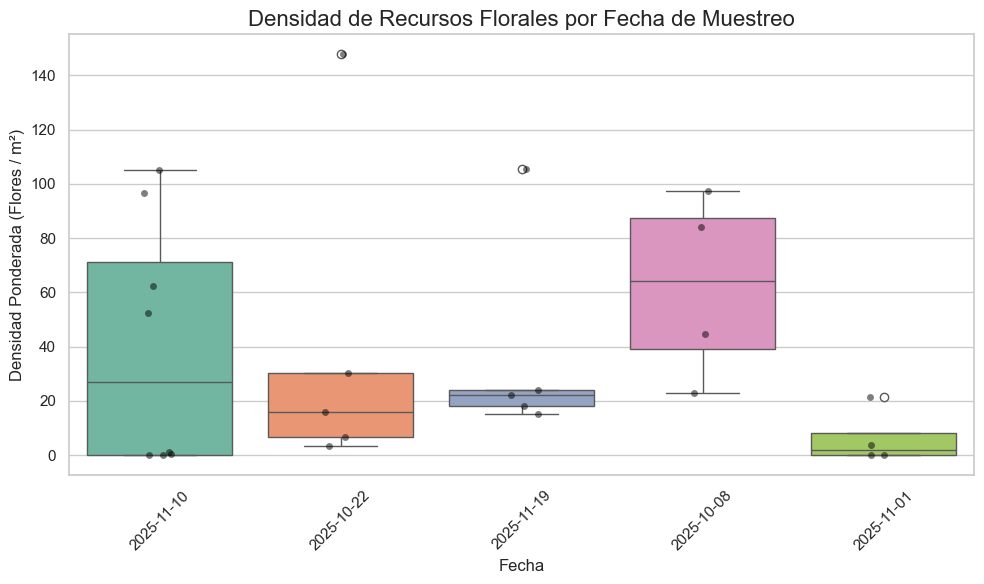

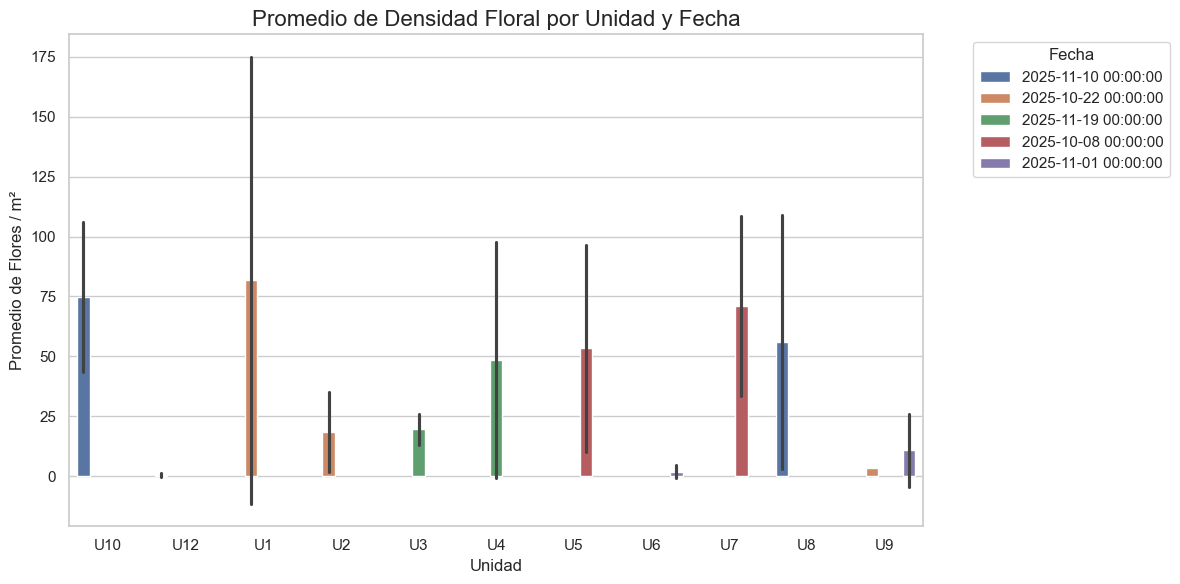

In [ ]:
# GRÁFICA 1: Boxplot (Cajas y Bigotes)
# Ideal para ver la caída de flores a través del tiempo y la variabilidad
plt.figure(figsize=(10, 6))
sns.boxplot(x=Campos.FECHA, y=Campos.DENSIDAD_PONDERADA, data=df_sitios, hue=Campos.FECHA, palette="Set2", legend=False)
sns.stripplot(x=Campos.FECHA, y=Campos.DENSIDAD_PONDERADA, data=df_sitios, color='black', alpha=0.5, jitter=True)

plt.title('Densidad de Recursos Florales por Fecha de Muestreo', fontsize=16)
plt.ylabel('Densidad Ponderada (Flores / m²)', fontsize=12)
plt.xlabel('Fecha', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# GRÁFICA 2: Comparación por Unidad (Para ver el efecto espacial)
plt.figure(figsize=(12, 6))
sns.barplot(x=Campos.UNIDAD, y=Campos.DENSIDAD_PONDERADA, hue=Campos.FECHA, data=df_sitios, errorbar='sd')
plt.title('Promedio de Densidad Floral por Unidad y Fecha', fontsize=16)
plt.ylabel('Promedio de Flores / m²', fontsize=12)
plt.legend(title='Fecha', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Modelo Lineal Mixto (LMM)

In [ ]:
# DEFINICIÓN DEL MODELO
# Variable Respuesta: Densidad_Ponderada
# Efecto Fijo: Fecha (Queremos ver cómo cambia con el tiempo)
# Efecto Aleatorio: Unidad (Agrupamos por U1, U2, etc.)

# Usamos C(Fecha) para tratar la fecha como categoría y no como número continuo
modelo = smf.mixedlm(f"{Campos.DENSIDAD_PONDERADA} ~ C({Campos.FECHA})", df_sitios, groups=df_sitios[Campos.UNIDAD])

try:
    resultado = modelo.fit()
    print(resultado.summary())
except Exception as e:
    print(f"El modelo no pudo converger (posiblemente pocos datos): {e}")

# INTERPRETACIÓN RÁPIDA AUTOMÁTICA
print("-" * 50)
print("INTERPRETACIÓN PRELIMINAR:")
p_values = resultado.pvalues
significant_dates = p_values[p_values < 0.05].index.tolist()

if not significant_dates:
    print("-> No se encontraron diferencias estadísticamente significativas (p<0.05) entre las fechas,")
    print("   pero revisa los valores 'P>|z|' en la tabla de arriba. Si son cercanos a 0.05 (ej. 0.06),")
    print("   puedes hablar de una 'tendencia marginal'.")
else:
    print(f"-> Se encontraron diferencias significativas en: {significant_dates}")

                           Mixed Linear Model Regression Results
Model:                     MixedLM          Dependent Variable:          Densidad_Ponderada
No. Observations:          26               Method:                      REML              
No. Groups:                11               Scale:                       1692.2317         
Min. group size:           2                Log-Likelihood:              -112.7688         
Max. group size:           3                Converged:                   Yes               
Mean group size:           2.4                                                             
-------------------------------------------------------------------------------------------
                                              Coef.  Std.Err.   z    P>|z|  [0.025   0.975]
-------------------------------------------------------------------------------------------
Intercept                                     62.188   23.209  2.679 0.007   16.699 107.676
C(Fecha)[T.Time